# Hand-written Digit Recognition usin Convolutional Neural Networks in Keras

In this notebook we will create a simple, but efficient ConvNet to achive nice result on digit recognition problem. For this purpose, we will use well-known [MNIST](http://yann.lecun.com/exdb/mnist/) database developed by Yann LeCun, Corinna Cortes and Christopher Burges.

In [1]:
#import libraries, they are compatible with Keras 2.08
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(211)

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


There are many different ways to capture MNIST data. I created this model for [Kaggle competition](https://www.kaggle.com/c/digit-recognizer/data), so this is my source of data. To ensure consistency, I suggest you download the same. 

In [2]:
#load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# assign the target to Y_train and leave features in X_train
Y_train = train['label']
X_train = train.drop('label', axis = 1)

## Data wrangling

We may expect that our target has uniform (regular) distribution, so let's prove this by creating an appropriate plot. To be ready for modelling, a few actions have to follow:

1. Normalize images (divide them by the number of pixel intensity)
1. Reshape variables containing features using following pattern: (-1 [Keras will automatically adjust this number to match remaining ones], image_height, image_width, colour_scale[1 for grey images and 3 for RGB]
1. Convert categorical data using one-hot encode 
1. Split the train data 

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

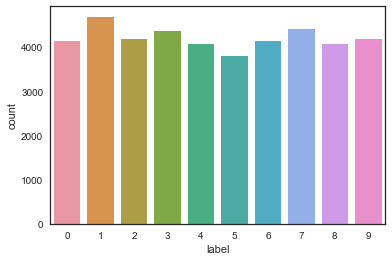

In [4]:
# plot the distribution of target variable
g = sns.countplot(Y_train)
Y_train.value_counts()

In [5]:
# make sure there is no missing pixels
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
#normalize
X_train = X_train / 255
test = test / 255

In [7]:
#reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [8]:
#one-hot encoding
Y_train = to_categorical(Y_train)

In [9]:
#split the train and validations sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=111)

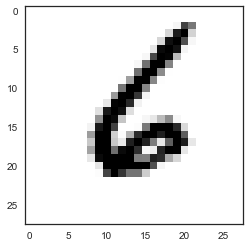

In [10]:
# sample picture
plt.imshow(X_train[8][:,:,0], cmap='Greys')

## ConvNet model

Once the data has been prepared, it's time for make use of Keras and create a model. Let's implement the following design: 
$ (Conv2D -> Conv2D -> MaxPooling -> Dropout) x 2 -> Flatten -> Fully Connected Layer -> Dropout -> SoftMax $

In [11]:
model = Sequential()
model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(28,28,1)))
model.add(Conv2D(32, (5,5), activation='relu', padding='same'))
model.add(MaxPool2D())
model.add(Dropout(0.25))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Our model needs to be compiled now. 'Categorical crossentropy' loss function works perfectly for classification problems with more that two outcomes. 'RMSprop' optimizer allows to minimize the cost function efficiently. Other optimizer being commonly used, 'Adam', will work fine too.

In [12]:
model.compile(loss="categorical_crossentropy", optimizer = 'RMSprop', metrics = ['accuracy'])

Let our learning rate decrease to prevent plateauing.

In [13]:
#set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

Running through 50 epochs will lead to decent results. Each epoc requires about 25s of processing time on my GPU (CUDA compute capability score = 5). 

In [14]:
# set the number of epochs and the batch_size
epochs = 50
batch_size = 200

In [15]:
#train the model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[learning_rate_reduction])

Train on 37800 samples, validate on 4200 samples
Epoch 1/50
27s - loss: 0.3312 - acc: 0.8942 - val_loss: 0.0775 - val_acc: 0.9731
Epoch 2/50
25s - loss: 0.0857 - acc: 0.9735 - val_loss: 0.0543 - val_acc: 0.9831
Epoch 3/50
25s - loss: 0.0614 - acc: 0.9816 - val_loss: 0.0446 - val_acc: 0.9871
Epoch 4/50
25s - loss: 0.0491 - acc: 0.9847 - val_loss: 0.0371 - val_acc: 0.9881
Epoch 5/50
25s - loss: 0.0404 - acc: 0.9876 - val_loss: 0.0415 - val_acc: 0.9883
Epoch 6/50
25s - loss: 0.0346 - acc: 0.9890 - val_loss: 0.0327 - val_acc: 0.9914
Epoch 7/50
25s - loss: 0.0306 - acc: 0.9905 - val_loss: 0.0291 - val_acc: 0.9907
Epoch 8/50
25s - loss: 0.0284 - acc: 0.9912 - val_loss: 0.0317 - val_acc: 0.9898
Epoch 9/50
25s - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0307 - val_acc: 0.9931
Epoch 10/50
25s - loss: 0.0219 - acc: 0.9929 - val_loss: 0.0304 - val_acc: 0.9940
Epoch 11/50
25s - loss: 0.0232 - acc: 0.9926 - val_loss: 0.0297 - val_acc: 0.9933
Epoch 12/50
25s - loss: 0.0200 - acc: 0.9943 - val_loss: 0

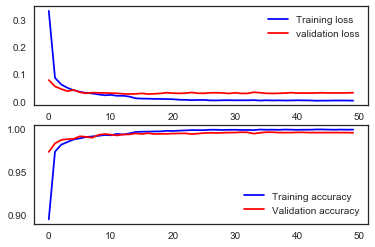

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Concluding our research, ConvNet model turned out to be a very good tool for this kind of problem, achieving impressive 99.57% accuracy.